In [1]:
!pip install -U bmaclient

Requirement already up-to-date: bmaclient in /home/lenovo/.local/lib/python3.8/site-packages (0.15.1)


In [2]:
import os
import json

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from bmaclient import MonitoringAPI
from bmaclient.utils import get_api_key
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import datetime as dt
import scipy
from scipy import signal
import statsmodels.api as sm

In [3]:
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
# client = MonitoringAPI(api_key='1JPZxKW5.RCpwvwK5O4T5hYFTzfPpSp9o2PdTtRwa')



def gps_data(start, end, station):
    client = MonitoringAPI(api_key='1JPZxKW5.RCpwvwK5O4T5hYFTzfPpSp9o2PdTtRwa')
    results = client.fetch_gps_position(
    timestamp__gte=start,
    timestamp__lt=end,
    station =station,
    nolimit=True,
    aggregation='mean')
    return results


In [4]:
# Linear Regression calculation

def lin_reg(station):
    #Change timestamp data type to numerical value
    station['timestamp'] = pd.to_datetime(station['timestamp'])
    station['timestamp']=station['timestamp'].map(dt.datetime.toordinal)
    #Median filter
    station['east']= scipy.signal.medfilt(station['east'],kernel_size=3)
    station['north']= scipy.signal.medfilt(station['north'],kernel_size=3)

    #Linear Regression
    X = sm.add_constant(station['timestamp'])
    modelgx = sm.OLS(station['east'],X)
    resultsgx = modelgx.fit()
    y_predictgx = resultsgx.params[0] + resultsgx.params[1]*station['east']

    X = sm.add_constant(station['timestamp'])
    modelgy = sm.OLS(station['north'],X)
    resultsgy = modelgy.fit()
    y_predictgy = resultsgy.params[0] + resultsgy.params[1]*station['timestamp']
    
    return resultsgx.params[0],resultsgx.params[1],resultsgy.params[0],resultsgy.params[1]

In [5]:
# Vector plot

def vector_res(x,y):
    # Select length of axes and the space between tick labels
    xmin, xmax, ymin, ymax = -0.0025, 0.0025, -0.0009, 0.0009
    ticks_frequency = 0.001
    origin = (0,0)

    # Plot points
    fig, ax = plt.subplots(figsize=(10, 10))


    fig.add_subplot(ax)
    ax.quiver(*origin, x, y, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.set_xlim(-0.001,0.001)
    ax.set_ylim(-0.001,0.001)

    # Set bottom and left spines as x and y axes of coordinate system
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')


    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    # Create 'x' and 'y' labels placed at the end of the axes
    ax.set_xlabel('x', size=14, labelpad=-24, x=1.03)
    ax.set_ylabel('y', size=14, labelpad=-21, y=1.02, rotation=0)
    ax.legend()

    # Draw major and minor grid lines
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

    # Draw arrows
    arrow_fmt = dict(markersize=4, color='black', clip_on=False)
    ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
    ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

    plt.show()


/tmp/ipykernel_5513/3864016749.py:44: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_5513/3864016749.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = np.vstack(map(np.ravel, [X, Y, Z])).T


(10000, 3)
5000


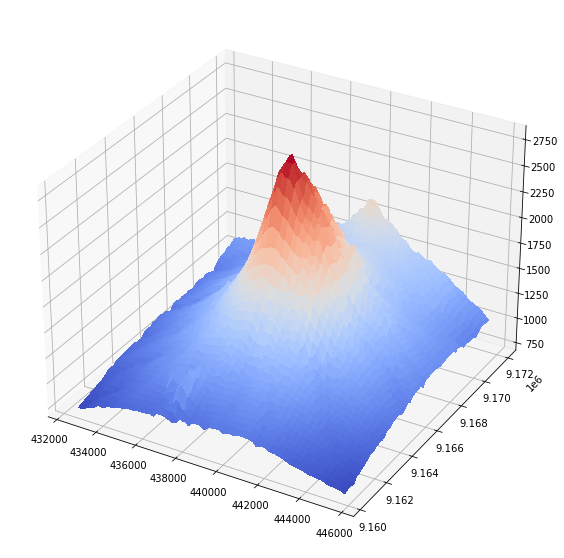

In [6]:
def read_grd(filename):
    with open(filename) as infile:
        name = infile.readline()

        nx = infile.readline().split()
        ncols = int(nx[0])
        nrows = int(nx[1])

        xlo = infile.readline().split()
        xmin = float(xlo[0])
        xmax = float(xlo[1])

        ylo = infile.readline().split()
        ymin = float(ylo[0])
        ymax = float(ylo[1])

        zlo = infile.readline().split()
        zmin = float(zlo[0])
        zmax = float(zlo[1])

        result = []
        for i in range(nrows):
            arr = []
            while True:
                string = infile.readline().split()
                if string:
                    arr += [float(s) for s in string]
                else:
                    break
            result.append(arr)

    longitude = np.linspace(xmin, xmax, ncols)
    latitude = np.linspace(ymin, ymax, nrows)

    return longitude, latitude, np.array(result)


def main():
    filename = 'out.grd'
    val = read_grd(filename)


    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    X, Y = np.meshgrid(val[0], val[1])
    Z = val[2]
    positions = np.vstack(map(np.ravel, [X, Y, Z])).T
    print(positions.shape)

    res = []
    for index, item in enumerate(positions.tolist()):
        if index % 2 != 0:
            res.append(item)

    print(len(res))

    with open('data.json', 'w') as f:
        json.dump(res, f, indent=4)
    surf = ax.plot_surface(X, Y, val[2], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    

    plt.show()

if __name__ == '__main__':
    main()

In [7]:
#Running the function for each location

#Deles No Data
#deles = gps_data('2022-03-01','2022-03-10','deles')
#deles = pd.DataFrame(deles)
#vecdel = lin_reg(deles)

grawah = gps_data('2022-03-01','2022-04-10','grawah')
grawah = pd.DataFrame(grawah)
vecgra = lin_reg(grawah)

selo = gps_data('2022-03-01','2022-04-10','selo')
selo = pd.DataFrame(selo)
vecsel = lin_reg(selo)

klatakan = gps_data('2022-03-01','2022-04-10','klatakan')
klatakan = pd.DataFrame(klatakan)
veckla = lin_reg(klatakan)

labuhan = gps_data('2022-03-01','2022-04-10','labuhan')
labuhan = pd.DataFrame(labuhan)
veclab = lin_reg(labuhan)

# Kendit No Data
#kendit = gps_data('2022-03-01','2022-05-10','kendit')
#kendit = pd.DataFrame(kendit)
#vecken = lin_reg(kendit)

babadan = gps_data('2022-03-01','2022-04-10','babadan')
babadan = pd.DataFrame(babadan)
vecbab = lin_reg(babadan)

pasbub = gps_data('2022-03-01','2022-04-10','pasarbubar')
pasbub = pd.DataFrame(pasbub)
vecpas = lin_reg(pasbub)

jrakah = gps_data('2022-03-01','2022-04-10','jrakah')
jrakah = pd.DataFrame(jrakah)
vecjra = lin_reg(jrakah)

plawangan = gps_data('2022-03-01','2022-04-10','plawangan')
plawangan = pd.DataFrame(plawangan)
vecpla = lin_reg(plawangan)

/tmp/ipykernel_5513/3644597769.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = np.vstack(map(np.ravel, [X, Y, Z])).T


(10000, 3)
5000


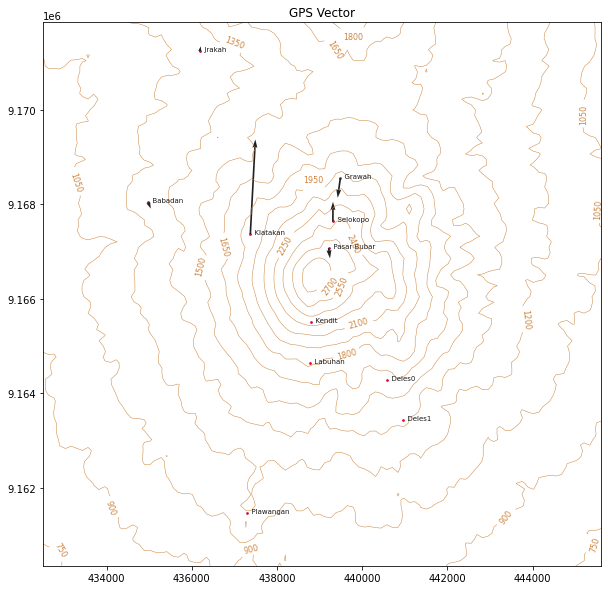

In [8]:
def main():
    filename = 'out.grd'
    val = read_grd(filename)



    X, Y = np.meshgrid(val[0], val[1])
    Z = val[2]
    positions = np.vstack(map(np.ravel, [X, Y, Z])).T
    print(positions.shape)

    res = []
    for index, item in enumerate(positions.tolist()):
        if index % 2 != 0:
            res.append(item)

    print(len(res))

    with open('data.json', 'w') as f:
        json.dump(res, f, indent=4)
        
   
    from pyproj import Proj
    e = np.array([440572.96, 439486.48, 439311.11, 440947.98, 437373.01, 438783.15, 438800.79, 434974.70, 439212.52, 436184.10, 437289.14])
    n = np.array([9164285.46, 9168551.49, 9167633.67, 9163442.39, 9167365.86, 9164632.56, 9165508.17, 9168037.08, 9167069.72, 9171233.72, 9161462.13])
    s = ['  Deles0', '  Grawah', '  Selokopo', '  Deles1', '  Klatakan', '  Labuhan', '  Kendit', '  Babadan', '  Pasar Bubar', '  Jrakah', '  Plawangan']
    
    #Vector parameter
    
    #orgdel = np.array([e[0],n[0]])
    #delx = vecdel[0]-orgdel[0]
    #dely = vecdel[2]-orgdel[1]

    orggra = np.array([e[1],n[1]])
    grax = vecgra[1]*orggra[0]
    gray = vecgra[3]*orggra[1]
    
    orgsel = np.array([e[2],n[2]])
    selx = vecsel[1]*orgsel[0]
    sely = vecsel[3]*orgsel[1]
    
    orgkla = np.array([e[4],n[4]])
    klax = veckla[1]*orgkla[0]
    klay = veckla[3]*orgkla[1]
    
    orglab = np.array([e[5],n[5]])
    labx = veclab[1]*orglab[0]
    laby = veclab[3]*orglab[1]
    
    #orgken = np.array([e[6],n[6]])
    #kenx = vecken[0]-orgken[0]
    #keny = vecken[2]-orgken[1]
    
    orgbab = np.array([e[7],n[7]])
    babx = vecbab[1]*orgbab[0]
    baby = vecbab[3]*orgbab[1]
    
    orgpas = np.array([e[8],n[8]])
    pasx = vecpas[1]*orgpas[0]
    pasy = vecpas[3]*orgpas[1]
    
    orgjra = np.array([e[9],n[9]])
    jrax = vecjra[1]*orgjra[0]
    jray = vecjra[3]*orgjra[1]
    
    orgpla = np.array([e[10],n[10]])
    plax = vecpla[1]*orgpla[0]
    play = vecpla[3]*orgpla[1]


    fig, ax = plt.subplots(figsize=(10,10))
    for i, txt in enumerate(s):
        ax.scatter(e[i],n[i], color='crimson', s=12, marker='.')
        ax.annotate(txt, (e[i],n[i]), size=7, color="#181818")   
    fig.add_subplot(ax)
    contours = ax.contour(X, Y, Z, colors='peru',antialiased='False', levels=15, linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8)
    ax.set_title('GPS Vector')
    
    #Vector Plot
    ax.quiver(*orggra, grax, gray, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orgsel, selx, sely, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orgkla, klax, klay, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orglab, labx, laby, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orgbab, babx, baby, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orgpas, pasx, pasy, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orgjra, jrax, jray, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    ax.quiver(*orgpla, plax, play, angles='xy', scale_units='xy',scale = 1, width=0.003, color='#212121')
    
    plt.savefig('GPS Vector.jpg')
if __name__ == '__main__':
    main()

In [42]:
def main():
    filename = 'out.grd'
    val = read_grd(filename)


    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    X, Y = np.meshgrid(val[0], val[1])
    Z = val[2]
    positions = np.vstack(map(np.ravel, [X, Y, Z])).T
    print(positions.shape)

    res = []
    for index, item in enumerate(positions.tolist()):
        if index % 2 != 0:
            res.append(item)

    print(len(res))

    with open('data.json', 'w') as f:
        json.dump(res, f, indent=4)
    surf = plt.plot(X, Z)
    #ax.view_init(azim=0, elev=100)
    
    plt.show()

if __name__ == '__main__':
    main()

/tmp/ipykernel_5513/3666668624.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_5513/3666668624.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = np.vstack(map(np.ravel, [X, Y, Z])).T


(10000, 3)
5000


ValueError: input operand has more dimensions than allowed by the axis remapping

AttributeError: 'Line3D' object has no attribute '_verts3d'

<Figure size 720x720 with 1 Axes>

/tmp/ipykernel_5513/4066485619.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_5513/4066485619.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = np.vstack(map(np.ravel, [X, Y, Z])).T


(10000, 3)
5000


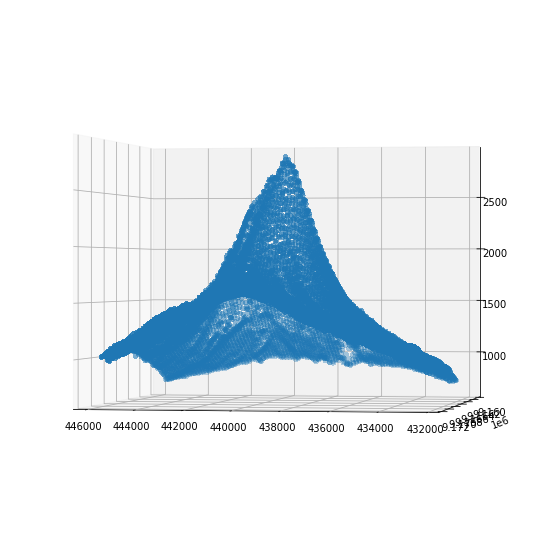

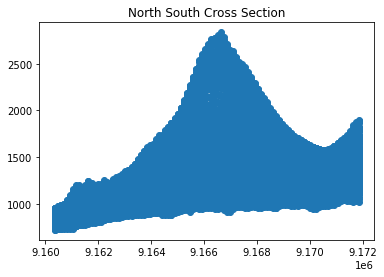

In [73]:
def main():
    filename = 'out.grd'
    val = read_grd(filename)


    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    X, Y = np.meshgrid(val[0], val[1])
    Z = val[2]
    positions = np.vstack(map(np.ravel, [X, Y, Z])).T
    print(positions.shape)

    res = []
    for index, item in enumerate(positions.tolist()):
        if index % 2 != 0:
            res.append(item)

    print(len(res))

    with open('data.json', 'w') as f:
        json.dump(res, f, indent=4)
    surf = ax.scatter(X,Y,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.view_init(azim=100, elev=0)
    plt.show()
    plt.scatter(Y,Z)
    plt.title('North South Cross Section')
    
    
if __name__ == '__main__':
    main()